In [2]:
from templates import *
import matplotlib.pyplot as plt
import numpy as np
from math import acos, sin
import SimpleITK as sitk
from tqdm import tqdm
import sys

import torch

# GPU 설정 및 device 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
file_path = "/workspace/storage/kjh/cardiac/DMCVR/test/cropped_sax_4d.nii.gz"
filling    = 5                             # 1장씩 보간
opt_idx    = 1                             # 최적화할 '보간 슬라이스'의 인덱스 (0부터 시작)
num_steps  = 200                           # x_t 최적화 스텝 수
lr         = 1e-2                          # x_t 학습률

skipping=0 #1 is interpolating each slice (filling the blanks) n,n+1,n+2
t=30
isxTInt=False #Do we interpolated xT with slerp or just use the previous xT

In [4]:
k =0
conf = autoenc_base()
conf.img_size = 128
conf.net_ch = 128
conf.net_ch_mult = (1, 1, 2, 3, 4)
conf.net_enc_channel_mult = (1, 1, 2, 3, 4, 4)
conf.model_name = ModelName.beatgans_autoenc

conf.name = 'med256_autoenc'
conf.make_model_conf()

>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++


BeatGANsAutoencConfig(image_size=128, in_channels=1, model_channels=128, out_channels=1, num_res_blocks=2, num_input_res_blocks=None, embed_channels=512, attention_resolutions=(16,), time_embed_channels=None, dropout=0.1, channel_mult=(1, 1, 2, 3, 4), input_channel_mult=None, conv_resample=True, dims=2, num_classes=None, use_checkpoint=False, num_heads=1, num_head_channels=-1, num_heads_upsample=-1, resblock_updown=True, use_new_attention_order=False, resnet_two_cond=True, resnet_cond_channels=None, resnet_use_zero_module=True, attn_checkpoint=False, enc_out_channels=512, enc_attn_resolutions=None, enc_pool='adaptivenonzero', enc_num_res_block=2, enc_channel_mult=(1, 1, 2, 3, 4, 4), enc_grad_checkpoint=False, latent_net_conf=None)

In [8]:
model = LitModel(conf)
# breakpoint()
state = torch.load(f'/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_multi/checkpoints_multi/med256_autoenc/epoch=295-step=708500.ckpt', map_location=device)
model.load_state_dict(state['state_dict'], strict=True)
model.ema_model.eval()
model.ema_model.to(device)

Seed set to 0


>>> model_name = ModelName.beatgans_autoenc
autoenc!!!!!!!!!!++++++++++
Model params: 122.58 M


/tmp/ipykernel_1261991/2388859264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_multi/check

BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias

In [6]:
# 3) NIfTI 로드 → numpy (Z,H,W)
img_itk = sitk.ReadImage(file_path)
vol_np  = sitk.GetArrayFromImage(img_itk)

# 4) intensity normalize
mx = np.percentile(vol_np, 98)
vol_np = np.clip(vol_np, 0, mx) / mx
vol_np = vol_np * 2.0 - 1.0

In [7]:
# 1) NumPy 로드 및 NaN 처리
gt_np = sitk.GetArrayFromImage(
    sitk.ReadImage("/workspace/storage/kjh/cardiac/DMCVR/test/combined_overlay_4d.nii.gz")
).astype(np.float32)
gt_np[gt_np == 0] = np.nan    # outside → NaN

# 2) 정규화 기준값 계산 (NaN 무시)
mx = np.nanpercentile(gt_np, 98)

# 3) Min–Max 정규화 (NaN 은 그대로)
gt_np_norm = np.clip(gt_np, 0, mx) / mx

# 4) Torch 텐서로 변환
region_gt = torch.from_numpy(gt_np_norm).float().to(device)


In [9]:
# 5) 빈 슬라이스(모두 0) 제거
nonzero_idx = [i for i in range(len(vol_np)) if vol_np[i].max() != 0]
vol_nz      = vol_np[nonzero_idx]

# # 6) 1,3,5,7,9번 슬라이스만 남기기 (0-based: 0,2,4,6,8)
# odd_idx = list(range(0, len(vol_nz), 2))
# vol_in   = vol_nz[odd_idx]  # shape = (5,H,W)

# sel_idx = [1, 2]              # 0→1st, 1→3rd, 2→5th, …
# vol_sel = vol_in[sel_idx] 

In [ ]:
# region_gt = region_gt[3]   # 4~6슬라이스 보간이라서 gt는 5번째 slice
# real_data = vol_nz[3]

In [ ]:
# odd_idx

[0, 2, 4, 6, 8, 10]

In [10]:
# 선형 보간 l_sem
def lin_interpolate(slice_1,slice_2,num=filling):
    #num is how many slices need to be inserted
    alpha=1.0/(num-1.0)
    out=[]
    # out.append(slice_1)
    for i in range(num-1):
        out.append((i)*alpha*slice_2+(1.0-(i)*alpha)*slice_1)
    # out.append(slice_2)
    return out

def slerp(x0: torch.Tensor, x1: torch.Tensor, alpha: float) -> torch.Tensor:
    """Spherical Linear intERPolation
    Args:
        x0 (`torch.Tensor`): first tensor to interpolate between
        x1 (`torch.Tensor`): seconds tensor to interpolate between
        alpha (`float`): interpolation between 0 and 1
    Returns:
        `torch.Tensor`: interpolated tensor
    """

    theta = acos(torch.dot(torch.flatten(x0), torch.flatten(x1)) / torch.norm(x0) / torch.norm(x1))
    return sin((1 - alpha) * theta) * x0 / sin(theta) + sin(alpha * theta) * x1 / sin(theta)

def slerp_np(x0: np.ndarray, x1: np.ndarray, alpha: float) -> np.ndarray:
    """Spherical Linear intERPolation
    Args:
        x0 (`torch.Tensor`): first tensor to interpolate between
        x1 (`torch.Tensor`): seconds tensor to interpolate between
        alpha (`float`): interpolation between 0 and 1
    Returns:
        `torch.Tensor`: interpolated tensor
    """

    theta = acos(np.dot(x0.flatten(), x1.flatten()) / np.linalg.norm(x0) / np.linalg.norm(x1))
    return sin((1 - alpha) * theta) * x0 / sin(theta) + sin(alpha * theta) * x1 / sin(theta)

# 구형 보간 - X_t
def slerp_interpolate(slice_1,slice_2,num=filling):
    #num is how many slices need to be inserted
    alpha=1.0/(num-1)
    out=[]
    # out.append(slice_1)
    for i in range(num-1):
        out.append(slerp_np(slice_1,slice_2,alpha*i))
    # out.append(slice_2)
    return out

In [11]:
# 7) Torch tensor 변환 & 모델 인코딩
img_tensor  = torch.from_numpy(vol_nz).float().unsqueeze(1).to(device)  
cond_tensor = model.encode(img_tensor)                                
xTs         = model.encode_stochastic(img_tensor, cond_tensor, T=t)       # x_0를 DDIM reverse sampling을 이용해 최종 noise 레벨 x_t (latent) 까지 역변환하고, 그 결과 (deterministic)

# 8) 보간(interpolation)
xTs_np  = xTs.cpu().numpy()
cond_np = cond_tensor.cpu().numpy()
final_x, final_c = [], []
for i in range(xTs_np.shape[0]-1):
    final_x.append(xTs_np[i]); final_c.append(cond_np[i])
    mid_x = slerp_interpolate(xTs_np[i], xTs_np[i+1], num=filling)
    mid_c = lin_interpolate(cond_np[i],  cond_np[i+1],  num=filling)
    final_x.extend(mid_x); final_c.extend(mid_c)
final_x.append(xTs_np[-1]); final_c.append(cond_np[-1])

interp_xTs   = torch.from_numpy(np.stack(final_x)).float().to(device)
interp_conds = torch.from_numpy(np.stack(final_c)).float().to(device)

/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/diffusion/base.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):


In [12]:
# 9) 보간된 한 슬라이스(x)만 골라서 최적화
x_t_slice = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True)
cond_slice = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True)
optimizer  = torch.optim.Adam([x_t_slice, cond_slice], lr=lr)


In [13]:
print(x_t_slice.shape)
print(region_gt.shape)


torch.Size([1, 1, 128, 128])
torch.Size([111, 128, 128])


In [14]:
region_gt = region_gt.unsqueeze(0)

In [ ]:
region_gt.shape ????????????

torch.Size([1, 111, 128, 128])

In [16]:
x_t_slice_init = x_t_slice.detach().clone()
cond_slice_init = cond_slice.detach().clone()

In [17]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# %matplotlib inline

# with torch.no_grad():

#     pred = model.render(x_t_slice_init,      cond=cond_slice_init,      T=t)


# final_np = pred.squeeze(0).squeeze(0).cpu().numpy()

# # plt.imshow(region_gt_np, cmap='gray')
# # plt.imshow(final_np, cmap='gray')
# # plt.show()


# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(region_gt_np,  cmap='gray')
# axes[0].set_title('region_gt_np')
# axes[0].axis('off')

# axes[1].imshow(final_np, cmap='gray')
# axes[1].set_title('final_np')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


In [18]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# %matplotlib inline

# with torch.no_grad():

#     pred = model.render(x_t_slice_init,      cond=cond_slice_init,      T=t)


# final_np = pred.squeeze(0).squeeze(0).cpu().numpy()

# # plt.imshow(region_gt_np, cmap='gray')
# # plt.imshow(final_np, cmap='gray')
# # plt.show()


# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(region_gt_np,  cmap='gray')
# axes[0].set_title('region_gt_np')
# axes[0].axis('off')

# axes[1].imshow(final_np, cmap='gray')
# axes[1].set_title('final_np')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

In [19]:
# num_steps = 200

# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn
# import timm
# import torchvision.transforms as T
# import torch
# import torch.nn.functional as F

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # --- 실시간 그래프 세팅 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')
# ax.set_xlabel('step'); ax.set_ylabel('loss')
# ax.set_title('x_t_slice Optimization Loss')

# metrics = {'step': [], 'mse': [], 'ssim': [], 'psnr': []}

# # 1) 원본 render 보관
# orig_render = model.render

# # 2) 전역 변수로 현재 스텝 기록
# current_step = 0

# # --- ViT 퍼셉추얼 세팅 ---
# # 3) ViT 모델 불러오기 및 고정
# vit_model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)
# vit_model.eval()
# for p in vit_model.parameters():
#     p.requires_grad = False

# # 4) ViT 입력 전처리: 리사이즈 + Normalize
# vit_size = 224
# vit_norm = T.Compose([
#     T.Resize((vit_size, vit_size)),
#     T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
# ])

# def vit_features(x):
#     # x: [B,1,H,W] in [0,1]
#     x3 = x.repeat(1,3,1,1)            # 1→3채널
#     x3 = vit_norm(x3)                # 리사이즈+정규화
#     return vit_model.forward_features(x3)  # [B, C_vit]

# lambda_vit = 0.01

# # --- 최적화 루프 ---
# for step in range(num_steps):
#     current_step = step

#     with torch.enable_grad():
#         # (A) x_t_slice, cond_slice 준비
#         # … encode_stochastic, 보간 등 생략 …

#         # (B) render 호출
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)  # [1,1,H,W] in [0,1]

#         # (C) pixel MSE 손실
#         mask = region_mask.unsqueeze(0).to(device)   # (1,1,H,W)
#         gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)
#         loss = F.mse_loss(pred * mask, gt * mask)

#         # (D) ViT 퍼셉추얼 손실
#         feat_pred = vit_features(pred * mask)
#         feat_gt   = vit_features(gt   * mask)
#         vit_loss  = F.mse_loss(feat_pred, feat_gt)
#         loss = loss + lambda_vit * vit_loss

#         # (E) 로그
#         if step < 3:
#             print(f"[step {step}] mse={loss.item():.6f}, vit={vit_loss.item():.6f}")
#         else:
#             print(f"loss={loss.item():.6f}")

#         # (F) backward + optimizer
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # (G) 실시간 그래프 업데이트
#         loss_history.append(loss.item())
#         line.set_xdata(np.arange(len(loss_history)))
#         line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()

#         # (H) 0 스텝 및 매 50 스텝마다 지표 계산
#         if step == 0 or (step + 1) % 50 == 0:
#             with torch.no_grad():
#                 p = (pred * mask).squeeze().cpu().numpy()
#                 g = (gt   * mask).squeeze().cpu().numpy()
#                 mse_val  = np.mean((p - g) ** 2)
#                 ssim_val = ssim_fn(g, p, data_range=g.max()-g.min())
#                 psnr_val = psnr_fn(g, p, data_range=g.max()-g.min())
#                 print(f"→ Metrics @step {step}: "
#                       f"MSE={mse_val:.6f}, SSIM={ssim_val:.4f}, PSNR={psnr_val:.2f}dB")
#                 metrics['step'].append(step)
#                 metrics['mse'].append(mse_val)
#                 metrics['ssim'].append(ssim_val)
#                 metrics['psnr'].append(psnr_val)


In [20]:
# import numpy as np
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn
# import matplotlib.pyplot as plt
# import types, torch, torch.nn.functional as F
# from tqdm import tqdm

# # --- 실시간 그래프 세팅 (생략) ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')
# ax.set_xlabel('step'); ax.set_ylabel('loss')
# ax.set_title('x_t_slice Optimization Loss')

# metrics = {'epoch': [], 'mse': [], 'ssim': [], 'psnr': []}

# # 1) 원본 render 보관
# orig_render = model.render

# # 2) debug_render 정의 (생략, 필요시 유지)
# # …

# # 3) 바인딩 (필요시)
# # model.render = types.MethodType(debug_render, model)

# # 4) Training parameters
# num_epochs = 200       # 총 epoch 수
# num_steps  = 1      # 한 epoch당 step 수
# device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for epoch in range(num_epochs):
#     print(f"\n===== Epoch {epoch+1}/{num_epochs} 시작 =====")
#     for step in range(num_steps):
#         # (A) x_t_slice, cond 준비
#         # … encode_stochastic, interpolation 등 생략 …

#         # (B) render 호출
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         # (C) loss 계산
#         mask = region_mask.unsqueeze(0).to(device)      # (1,1,H,W)
#         gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)
#         loss = F.mse_loss(pred * mask, gt * mask)

#         # (D) 로그
#         print(f"[Epoch {epoch+1} Step {step+1}] loss={loss.item():.6f}")

#         # (E) backward + optimizer
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # (F) 실시간 그래프 업데이트
#         loss_history.append(loss.item())
#         line.set_xdata(range(len(loss_history)))
#         line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()

#     # --- 5 epoch마다 지표 계산 및 출력 ---
#     if (epoch + 1) % 5 == 0:
#         with torch.no_grad():
#             # 마지막 pred, gt 사용. 필요시 validation loop로 교체
#             p = (pred * mask).squeeze().cpu().numpy()
#             g = (gt   * mask).squeeze().cpu().numpy()
#             mse_val  = np.mean((p - g) ** 2)
#             ssim_val = ssim_fn(g, p, data_range=g.max() - g.min())
#             psnr_val = psnr_fn(g, p, data_range=g.max() - g.min())
#             print(f"\n>>> [Epoch {epoch+1}] Metrics:")
#             print(f"    MSE  = {mse_val:.6f}")
#             print(f"    SSIM = {ssim_val:.4f}")
#             print(f"    PSNR = {psnr_val:.2f} dB\n")
#             metrics['epoch'].append(epoch+1)
#             metrics['mse'].append(mse_val)
#             metrics['ssim'].append(ssim_val)
#             metrics['psnr'].append(psnr_val)

# print("Training 완료")


In [21]:
# ROI hard condition + prior loss

# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn
# import kornia.filters as KF

# # --- 사전 설정 ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mask = region_mask.unsqueeze(0).to(device)  # (1,1,H,W)

# gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)    # (1,1,H,W)

# # 실시간 그래프 세팅
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')
# ax.set_xlabel('Iteration')
# ax.set_ylabel('Loss')
# ax.set_title('x_t_slice + cond_slice Optimization Loss')

# # Metrics 저장용
# metrics = {'epoch': [], 'mse': [], 'ssim': [], 'psnr': []}

# # 하이퍼파라미터
# num_epochs   = 200
# num_steps    = 1
# lambda_latent = 0.1    # latent prior 가중치
# kernel_size   = 21     # soft blending kernel size (odd)
# sigma         = 7      # soft blending sigma
# alpha_proj    = 0.1    # latent projection 비율

# for epoch in range(num_epochs):
#     print(f"\n===== Epoch {epoch+1}/{num_epochs} 시작 =====")
#     for step in range(num_steps):
#         # 1) 현재 pred 생성
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,C,H,W)

#         # 2) ROI 하드 리플레이스
#         replaced = pred * (1 - mask) + gt * mask

#         # 3) soft mask 생성 (Gaussian blur)
#         # mask: (1,1,H,W) Tensor
#         soft_mask = KF.gaussian_blur2d(
#             mask.float(),
#             kernel_size=(kernel_size, kernel_size),
#             sigma=(sigma, sigma)
#         ).clamp(0.0, 1.0)

#         # 4) 주변 영역 soft update
#         blended = soft_mask * replaced + (1 - soft_mask) * pred

#         # 5) ROI 손실 계산
#         roi_loss = F.mse_loss(blended * mask, gt * mask)

#         # 6) latent prior regularization
#         latent_reg = torch.mean((x_t_slice - x_t_slice_init).pow(2))
#         cond_reg   = torch.mean((cond_slice - cond_slice_init).pow(2))
#         prior_loss = lambda_latent * (latent_reg + cond_reg)

#         # 7) 총 손실
#         loss = roi_loss + prior_loss

#         # 8) backward & 업데이트
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # 9) latent projection
#         with torch.no_grad():
#             x_t_slice.data = (1 - alpha_proj) * x_t_slice.data + alpha_proj * x_t_slice_init
#             cond_slice.data = (1 - alpha_proj) * cond_slice.data + alpha_proj * cond_slice_init

#         # 10) 로그
#         print(f"[Epoch {epoch+1} Step {step+1}] loss={loss.item():.6f}  "
#               f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")
#         loss_history.append(loss.item())
#         line.set_xdata(range(len(loss_history)))
#         line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()

#     # 5 epoch마다 지표 계산
#     if (epoch + 1) % 5 == 0:
#         with torch.no_grad():
#             pred_eval = model.render(x_t_slice, cond=cond_slice, T=t)
#             p = (pred_eval * mask).squeeze().cpu().numpy()
#             g = (gt        * mask).squeeze().cpu().numpy()
#             mse_val  = ((p - g) ** 2).mean()
#             ssim_val = ssim_fn(g, p, data_range=g.max() - g.min())
#             psnr_val = psnr_fn(g, p, data_range=g.max() - g.min())
#         print(f">>> [Epoch {epoch+1}] Metrics: MSE={mse_val:.6f}, SSIM={ssim_val:.4f}, PSNR={psnr_val:.2f}dB")
#         metrics['epoch'].append(epoch+1)
#         metrics['mse'].append(mse_val)
#         metrics['ssim'].append(ssim_val)
#         metrics['psnr'].append(psnr_val)

# print("Optimization 완료")


/usr/local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/workspace/storage/kjh/cardiac/DMCVR/generation/diffae_inverse/diffusion/base.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(self.conf.fp16):


cond_slice.grad norm = 0.140330
x_t_slice.grad norm = 0.037630
[E1S1] loss=0.594453 (roi=0.118891, prior=0.000000)
cond_slice.grad norm = 0.130291
x_t_slice.grad norm = 0.037294
[E2S1] loss=0.586861 (roi=0.117372, prior=0.000000)
cond_slice.grad norm = 0.122593
x_t_slice.grad norm = 0.036915
[E3S1] loss=0.579503 (roi=0.115901, prior=0.000001)
cond_slice.grad norm = 0.115310
x_t_slice.grad norm = 0.036671
[E4S1] loss=0.572597 (roi=0.114519, prior=0.000001)
cond_slice.grad norm = 0.110316
x_t_slice.grad norm = 0.036300
[E5S1] loss=0.566013 (roi=0.113202, prior=0.000002)
>>> [Epoch 5] MSE=0.156475, SSIM=0.2204, PSNR=8.00dB
cond_slice.grad norm = 0.105845
x_t_slice.grad norm = 0.036121
[E6S1] loss=0.559727 (roi=0.111945, prior=0.000003)
cond_slice.grad norm = 0.102116
x_t_slice.grad norm = 0.035905
[E7S1] loss=0.553655 (roi=0.110730, prior=0.000004)
cond_slice.grad norm = 0.096492
x_t_slice.grad norm = 0.035683
[E8S1] loss=0.547859 (roi=0.109571, prior=0.000006)
cond_slice.grad norm = 0.09

KeyboardInterrupt: 

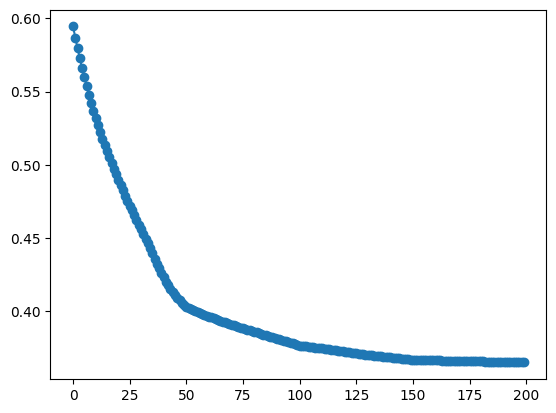

In [ ]:
# # final (base)

# import torch
# import torch.nn.functional as F
# import kornia.filters as KF
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn

# # --- 하이퍼파라미터 수정 ---
# num_epochs    = 300
# num_steps     = 1
# base_lr       = 2e-3       # LR 조정
# lambda_roi    = 5.0        # ROI loss weight 강화
# lambda_latent = 0.02       # latent prior 정규화 약하게
# kernel_size   = 21
# sigma         = 7
# alpha_proj    = 0.001

# # --- 초기 변수 셋업 ---
# device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice      = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice     = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init = x_t_slice.detach().clone()
# cond_slice_init= cond_slice.detach().clone()
# gt             = region_gt  .unsqueeze(0).unsqueeze(0).to(device)

# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# gt_clean = torch.nan_to_num(gt, nan=0.0)

# valid_mask = (~torch.isnan(gt)).float()   # (1,1,H,W): NaN 아닌 곳만 1
# n_valid    = valid_mask.sum()             # 유효 픽셀 수

# real_data_ = torch.from_numpy(real_data).float().unsqueeze(0).to(device)  

# # --- Gradient flow 점검용 hook 등록 ---
# def print_grad(name):
#     def hook(grad):
#         print(f"{name}.grad norm = {grad.norm().item():.6f}")
#     return hook

# x_t_slice.register_hook(print_grad("x_t_slice"))
# cond_slice.register_hook(print_grad("cond_slice"))

# # --- 실시간 그래프 세팅 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- Optimization Loop ---
# for epoch in range(num_epochs):
#     for step in range(num_steps):
#         # Forward
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         roi_loss = F.mse_loss(pred * valid_mask, real_data_ * valid_mask, reduction='sum')
#         roi_loss = roi_loss / n_valid
        
#         latent_reg = torch.mean((x_t_slice - x_t_slice_init).pow(2))
#         cond_reg   = torch.mean((cond_slice - cond_slice_init).pow(2))
#         prior_loss = lambda_latent * (latent_reg + cond_reg)
#         loss       = lambda_roi * roi_loss + prior_loss

#         # Backward & Optimizer
#         optimizer.zero_grad()
#         loss.backward()  # hook 실행: gradient norms 출력
#         optimizer.step()

#         # Projection
#         with torch.no_grad():
#             x_t_slice.data  = (1-alpha_proj)*x_t_slice.data  + alpha_proj*x_t_slice_init
#             cond_slice.data = (1-alpha_proj)*cond_slice.data + alpha_proj*cond_slice_init

#         # Logging & Plot
#         loss_history.append(loss.item())
#         line.set_xdata(range(len(loss_history))); line.set_ydata(loss_history)
#         ax.relim(); ax.autoscale_view()
#         fig.canvas.draw(); fig.canvas.flush_events()
#         print(f"[E{epoch+1}S{step+1}] loss={loss.item():.6f} "
#               f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     # LR scheduler step
#     scheduler.step()

#     # 5 epoch마다 metrics 계산 및 출력
#     if (epoch+1) % 5 == 0:
#         with torch.no_grad():
#             pred_eval = model.render(x_t_slice, cond=cond_slice, T=t)
#             p = (pred_eval).squeeze().cpu().numpy()
#             g = (real_data_).squeeze().cpu().numpy()
#             mse  = ((p - g) ** 2).mean()
#             ssim = ssim_fn(g, p, data_range=g.max() - g.min())
#             psnr = psnr_fn(g, p, data_range=g.max() - g.min())
#         print(f">>> [Epoch {epoch+1}] MSE={mse:.6f}, SSIM={ssim:.4f}, PSNR={psnr:.2f}dB")

# print("Optimization 완료")


/usr/local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


cond_slice.grad norm = 0.096115
x_t_slice.grad norm = 0.030979
[E1S1] loss=0.092104 (roi=0.018421, prior=0.000000)
cond_slice.grad norm = 0.071436
x_t_slice.grad norm = 0.029083
[E2S1] loss=0.089374 (roi=0.017875, prior=0.000000)
cond_slice.grad norm = 0.072459
x_t_slice.grad norm = 0.028710
[E3S1] loss=0.086713 (roi=0.017343, prior=0.000000)
cond_slice.grad norm = 0.069013
x_t_slice.grad norm = 0.028428
[E4S1] loss=0.083799 (roi=0.016760, prior=0.000001)
cond_slice.grad norm = 0.060962
x_t_slice.grad norm = 0.028072
[E5S1] loss=0.080951 (roi=0.016190, prior=0.000002)
>>> [Epoch 5] MSE=0.090888, SSIM=0.2022, PSNR=6.23dB
cond_slice.grad norm = 0.053357
x_t_slice.grad norm = 0.027795
[E6S1] loss=0.078363 (roi=0.015672, prior=0.000002)
cond_slice.grad norm = 0.056056
x_t_slice.grad norm = 0.027646
[E7S1] loss=0.076183 (roi=0.015236, prior=0.000003)
cond_slice.grad norm = 0.057348
x_t_slice.grad norm = 0.027261
[E8S1] loss=0.074250 (roi=0.014849, prior=0.000004)
cond_slice.grad norm = 0.05

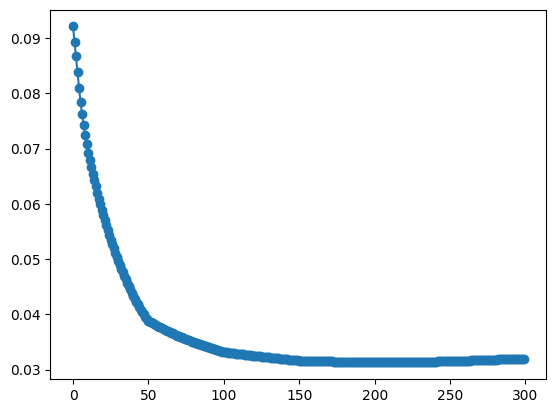

In [23]:
import torch
import torch.nn.functional as F
import kornia.filters as KF
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_fn, peak_signal_noise_ratio as psnr_fn

# --- 하이퍼파라미터 ---
num_epochs    = 300
num_steps     = 1
base_lr       = 2e-3
lambda_roi    = 5.0
lambda_latent = 0.02
alpha_proj    = 0.001

# --- 디바이스 및 텐서 초기화 ---
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_t_slice      = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
cond_slice     = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
x_t_slice_init = x_t_slice.detach().clone()
cond_slice_init= cond_slice.detach().clone()
gt             = region_gt.unsqueeze(0).unsqueeze(0).to(device)

# --- GT clean & ROI mask ---
gt_clean    = torch.nan_to_num(gt, nan=0.0)
valid_mask  = (~torch.isnan(gt)).float()  # (1,1,H,W)
n_valid     = valid_mask.sum()
gt_roi      = gt_clean * valid_mask
mu_gt       = gt_roi.sum() / n_valid
sigma_gt    = torch.sqrt(((gt_roi - mu_gt) * valid_mask).pow(2).sum() / n_valid + 1e-6)

real_data_ = torch.from_numpy(real_data).float().unsqueeze(0).to(device)  
real_d = real_data_ * valid_mask

# --- Optimizer & Scheduler ---
optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# --- Gradient hook 등록 ---
def print_grad(name):
    def hook(grad):
        print(f"{name}.grad norm = {grad.norm().item():.6f}")
    return hook

x_t_slice.register_hook(print_grad("x_t_slice"))
cond_slice.register_hook(print_grad("cond_slice"))

# --- 실시간 그래프 세팅 ---
plt.ion()
fig, ax = plt.subplots()
loss_history = []
line, = ax.plot(loss_history, '-o')

# --- 최적화 루프 ---
for epoch in range(num_epochs):
    for step in range(num_steps):
        # 1) Forward
        pred = model.render(x_t_slice, cond=cond_slice, T=t)

        # 2) Pred ROI 통계 업데이트
        pred_roi   = pred * valid_mask
        mu_pred    = pred_roi.sum() / n_valid
        sigma_pred = torch.sqrt(((pred_roi - mu_pred) * valid_mask).pow(2).sum() / n_valid + 1e-6)

        # 3) Affine normalization
        pred_norm     = (pred - mu_pred) * (sigma_gt / sigma_pred) + mu_gt
        pred_norm_roi = pred_norm * valid_mask

        # 4) ROI-only MSE loss
        roi_loss   = F.mse_loss(pred_norm_roi, real_d, reduction='sum') / n_valid

        # 5) Latent prior loss
        latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
        cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
        prior_loss = lambda_latent * (latent_reg + cond_reg)

        # 6) Total loss
        loss = lambda_roi * roi_loss + prior_loss

        # 7) Backward & Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 8) Projection
        with torch.no_grad():
            x_t_slice.data  = (1 - alpha_proj) * x_t_slice.data  + alpha_proj * x_t_slice_init
            cond_slice.data = (1 - alpha_proj) * cond_slice.data + alpha_proj * cond_slice_init

        # 9) Logging & Plot
        loss_history.append(loss.item())
        line.set_xdata(range(len(loss_history)))
        line.set_ydata(loss_history)
        ax.relim(); ax.autoscale_view()
        fig.canvas.draw(); fig.canvas.flush_events()
        print(f"[E{epoch+1}S{step+1}] loss={loss.item():.6f} "
              f"(roi={roi_loss.item():.6f}, prior={prior_loss.item():.6f})")

    scheduler.step()

    # 5 epoch마다 평가
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            pred_eval = model.render(x_t_slice, cond=cond_slice, T=t).squeeze().cpu().numpy()
            gt_eval   = gt.squeeze().cpu().numpy()
            mask_np   = valid_mask.squeeze().cpu().numpy().astype(bool)
            mse       = ((pred_eval[mask_np] - gt_eval[mask_np])**2).mean()
            ssim      = ssim_fn(real_data, pred_eval, data_range=gt_eval[mask_np].max() - gt_eval[mask_np].min())
            psnr      = psnr_fn(real_data, pred_eval, data_range=gt_eval[mask_np].max() - gt_eval[mask_np].min())
        print(f">>> [Epoch {epoch+1}] MSE={mse:.6f}, SSIM={ssim:.4f}, PSNR={psnr:.2f}dB")

print("Optimization 완료")


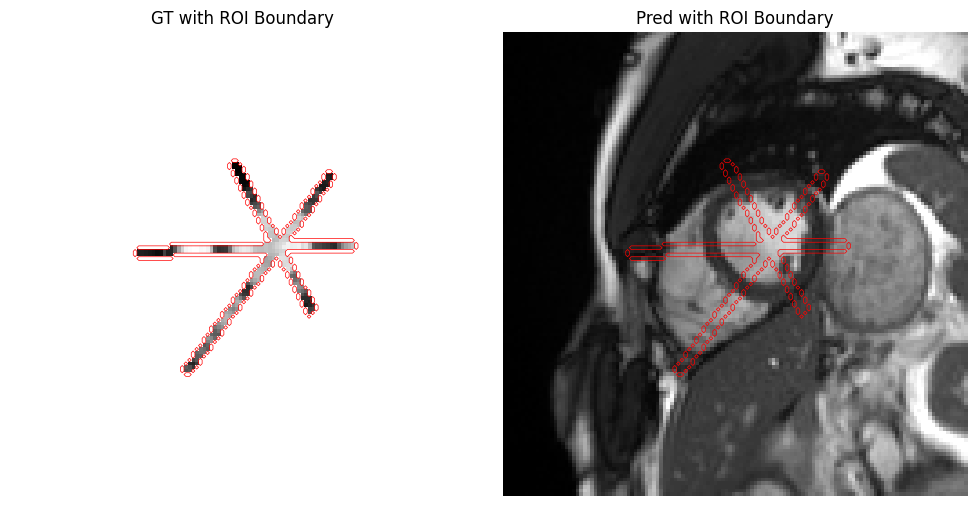

Statistics within ROI:
pred_mean: 0.445120
pred_max: 0.863946
pred_min: 0.044218
gt_mean: 0.495928
gt_max: 0.894890
gt_min: 0.082155


In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# Assume pred, gt, valid_mask are defined in the workspace
# pred: torch.Tensor (1,1,H,W)
# gt: torch.Tensor (1,1,H,W) with NaNs outside ROI
# valid_mask: torch.Tensor (1,1,H,W), 1 for valid ROI pixels

# Convert to numpy
# pred_np = pred.detach().cpu().squeeze().numpy()
gt_np = gt.detach().cpu().squeeze().cpu().numpy()
mask_np = valid_mask.detach().cpu().squeeze().numpy().astype(bool)

# Compute statistics
pred_vals = real_data[mask_np]
gt_vals = gt_np[mask_np]

stats = {
    'pred_mean': float(np.nanmean(pred_vals)),
    'pred_max': float(np.nanmax(pred_vals)),
    'pred_min': float(np.nanmin(pred_vals)),
    'gt_mean': float(np.nanmean(gt_vals)),
    'gt_max': float(np.nanmax(gt_vals)),
    'gt_min': float(np.nanmin(gt_vals))
}

# Visualize GT and Pred with ROI boundary
mask_edge = find_boundaries(mask_np, mode='outer')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_np, cmap='gray')
axs[0].contour(mask_edge, colors='r', linewidths=0.5)
axs[0].set_title('GT with ROI Boundary')
axs[0].axis('off')

axs[1].imshow(real_data, cmap='gray')
axs[1].contour(mask_edge, colors='r', linewidths=0.5)
axs[1].set_title('Pred with ROI Boundary')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print("Statistics within ROI:")
for k, v in stats.items():
    print(f"{k}: {v:.6f}")


In [ ]:
# import matplotlib.pyplot as plt

# # --- Optimization 완료 후 시각화 코드 ---
# with torch.no_grad():
#     # 1) Masked prediction과 real data 계산
#     masked_pred = pred * valid_mask      # pred: 마지막 step의 model output
#     masked_real = real_data_ * valid_mask

#     # 2) NumPy array로 변환
#     mp = masked_pred.squeeze().cpu().numpy()
#     mr = masked_real.squeeze().cpu().numpy()

# # 3) vmin, vmax 통일 (real data 범위 기준)
# vmin, vmax = mr.min(), mr.max()

# # 4) Figure 생성 및 시각화
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Real Data * Mask
# axes[0].imshow(mr, cmap='gray', vmin=vmin, vmax=vmax)
# axes[0].set_title('Real Data * valid_mask')
# axes[0].axis('off')

# # Pred * Mask
# axes[1].imshow(mp, cmap='gray', vmin=vmin, vmax=vmax)
# axes[1].set_title('Pred * valid_mask')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


In [25]:
with torch.no_grad():
    # 초기(최적화 전) 예측
    orig_pred = model.render(x_t_slice_init, cond=cond_slice_init, T=t)
    # 최적화된 예측
    final_pred = model.render(x_t_slice,      cond=cond_slice,      T=t)

# NumPy 배열로 변환
orig_np  = orig_pred .squeeze(0).squeeze(0).cpu().numpy()  # shape=(H,W)
final_np = final_pred.squeeze(0).squeeze(0).cpu().numpy()

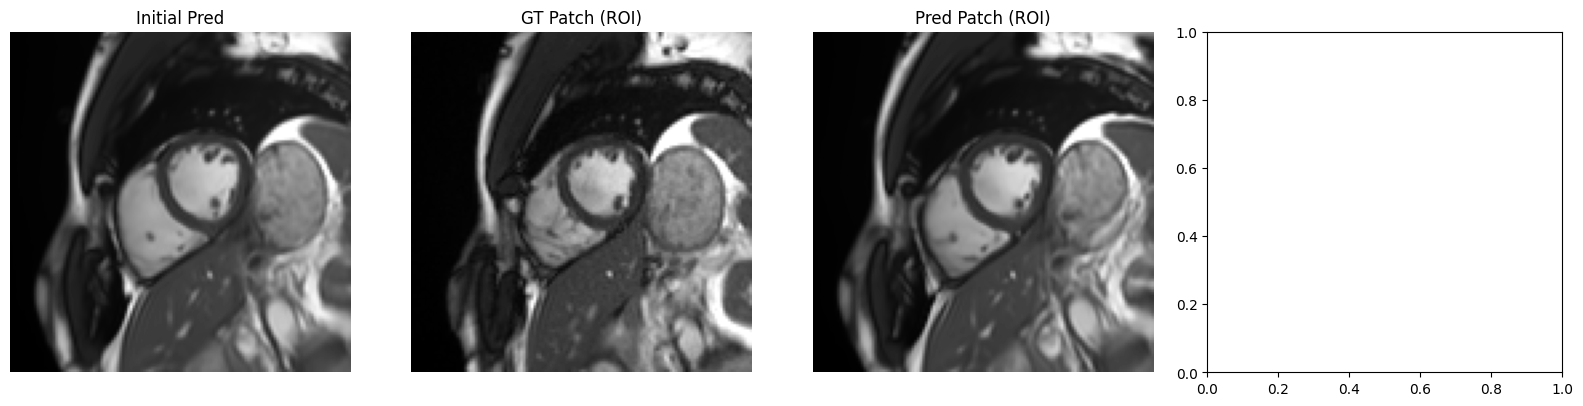

In [26]:
import matplotlib.pyplot as plt
import torch
from skimage.segmentation import find_boundaries

# 1) 초기 pred 계산
with torch.no_grad():
    pred_init = model.render(x_t_slice_init, cond=cond_slice_init, T=t)  # (1, C, H, W)
pred_init_img = pred_init.squeeze().cpu().numpy()  # (H, W)


# 2) mask, gt numpy 변환
# mask_np = (mask.squeeze().cpu().numpy() > 0.5)  # bool (H, W)
gt_np   = region_gt.squeeze().cpu().numpy()            # float (H, W)


# # 3) ROI 영역의 GT 패치와 Pred 패치
# gt_patch   = gt_np * mask_np                    # GT에서 mask 영역만
# # pred_patch = pred_init_img * mask_np            # Pred에서 mask 영역만

# # 4) mask 윤곽선 추출
# mask_edge = find_boundaries(mask_np, mode='outer')  # bool (H, W)

# 5) 시각화
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# (a) 초기 예측 전체
axs[0].imshow(pred_init_img, cmap='gray')
axs[0].set_title('Initial Pred')
axs[0].axis('off')

# (b) ROI GT 패치만
axs[1].imshow(real_data, cmap='gray')
axs[1].set_title('GT Patch (ROI)')
axs[1].axis('off')

# (c) ROI Pred 패치만
axs[2].imshow(final_np, cmap='gray')
axs[2].set_title('Pred Patch (ROI)')
axs[2].axis('off')

# # (d) Initial Pred 위에 GT 패치 윤곽선
# axs[3].imshow(gt_np, cmap='gray')
# # axs[3].contour(mask_edge, colors='r', linewidths=1.0)
# axs[3].set_title('Pred + GT ROI Edge')
# axs[3].axis('off')

plt.tight_layout()
plt.show()


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 0) NumPy 배열 준비 (이미 계산해 두신 상태라고 가정) ---
# pred_init_img: (H, W) NumPy array
# real_data:    (H, W) NumPy array — region_gt 기반 ROI 패치
# final_np:     (H, W) NumPy array — 최종 pred 패치

# 예시: 만약 real_data가 torch.Tensor라면
# real_data_np = real_data.squeeze().cpu().numpy()

# --- 1) 저장할 폴더 만들기 ---
output_dir = "/workspace/storage/kjh/cardiac/DMCVR/test/output/4-6"                          # 저장할 폴더 경로
os.makedirs(output_dir, exist_ok=True)                # 폴더가 없으면 생성

# --- 2) 이미지로 저장 ---
# (a) 초기 예측 전체
plt.imsave(
    os.path.join(output_dir, "pred_init.png"),
    pred_init_img,
    cmap="gray",
    vmin=pred_init_img.min(), vmax=pred_init_img.max()
)

# (b) GT Patch (ROI)
plt.imsave(
    os.path.join(output_dir, "real_data.png"),
    real_data,
    cmap="gray",
    vmin=real_data.min(), vmax=real_data.max()
)

# (c) Pred Patch (ROI)
plt.imsave(
    os.path.join(output_dir, "final_pred.png"),
    final_np,
    cmap="gray",
    vmin=final_np.min(), vmax=final_np.max()
)

np.save(os.path.join(output_dir, "pred_init_img.npy"), pred_init_img)
np.save(os.path.join(output_dir, "real_data.npy"),    real_data)
np.save(os.path.join(output_dir, "final_pred.npy"),   final_np)

print(f"Saved individual .npy files to `{output_dir}`")

print(f"저장 완료: {output_dir} 폴더를 확인하세요.")


Saved individual .npy files to `/workspace/storage/kjh/cardiac/DMCVR/test/output/4-6`
저장 완료: /workspace/storage/kjh/cardiac/DMCVR/test/output/4-6 폴더를 확인하세요.


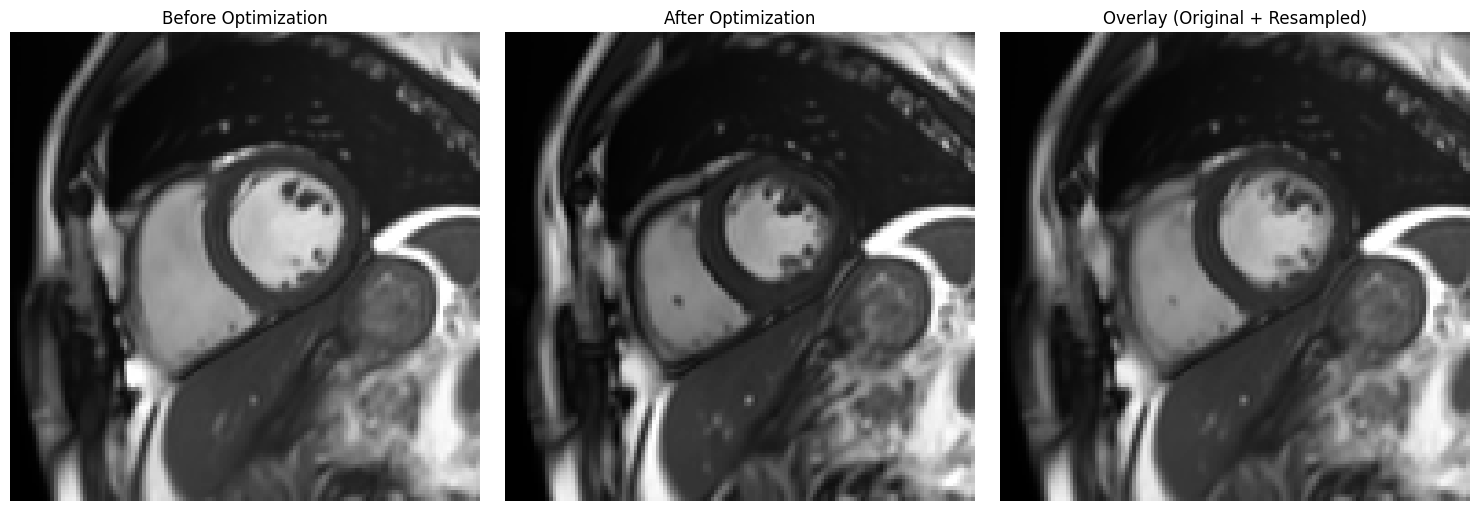

In [18]:
# --- 3) 나란히 시각화 ---

overlay  = 0.1 * orig_np + 0.1 * final_np


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(orig_np,  cmap='gray')
axes[0].set_title('Before Optimization')
axes[0].axis('off')

axes[1].imshow(final_np, cmap='gray')
axes[1].set_title('After Optimization')
axes[1].axis('off')

axes[2].imshow(overlay, cmap='gray')
axes[2].set_title('Overlay (Original + Resampled)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# # --- 4) (선택) NIfTI 로도 저장하고 싶다면 ---
# out0 = sitk.GetImageFromArray(orig_np)
# out1 = sitk.GetImageFromArray(final_np)
# # 원본과 spacing/origin/direction 맞추기
# out0.SetSpacing(orig_sp); out1.SetSpacing(orig_sp)
# out0.SetOrigin(orig_orig); out1.SetOrigin(orig_orig)
# out0.SetDirection(orig_dir); out1.SetDirection(orig_dir)
# sitk.WriteImage(out0, 'slice_before_opt.nii.gz')
# sitk.WriteImage(out1, 'slice_after_opt.nii.gz')

In [21]:
# import torch
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu, sobel

# # Assuming pred and gt are available as torch tensors (1,1,H,W)
# # Convert to numpy

# pred = model.render(x_t_slice_init, cond=cond_slice_init, T=t)
# gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)

# pred_np = pred.detach().cpu().squeeze().numpy()
# gt_np   = gt.detach().cpu().squeeze().numpy()

# # --- 실험 1: 이진화 (Otsu) ---
# th_p = threshold_otsu(pred_np)
# mask_p = pred_np > th_p

# # --- 실험 2: 경계 맵 (Sobel) ---
# edges_p = sobel(pred_np)
# edges_g = sobel(gt_np)

# # 시각화
# fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# # Row 1: 실험1
# axs[0,0].imshow(pred_np, cmap='gray')
# axs[0,0].set_title('Pred Image')
# axs[0,0].axis('off')

# axs[0,1].imshow(mask_p, cmap='gray')
# axs[0,1].set_title('Binary Mask (Otsu)')
# axs[0,1].axis('off')

# axs[0,2].hist(pred_np.ravel(), bins=50)
# axs[0,2].axvline(th_p, color='r')
# axs[0,2].set_title('Histogram & Threshold')

# # Row 2: 실험2
# axs[1,0].imshow(pred_np, cmap='gray')
# axs[1,0].set_title('Pred Image')
# axs[1,0].axis('off')

# axs[1,1].imshow(edges_p, cmap='gray')
# axs[1,1].set_title('Pred Edges (Sobel)')
# axs[1,1].axis('off')

# axs[1,2].imshow(edges_g, cmap='gray')
# axs[1,2].set_title('GT Edges (Sobel)')
# axs[1,2].axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
## 실험1
# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu
# from scipy.ndimage import distance_transform_edt

# # --- 하이퍼파라미터 ---
# num_epochs    = 300
# num_steps     = 1
# base_lr       = 2e-3
# # lambda_roi    = 5.0
# lambda_roi    = 5.0
# lambda_shape  = 1.0
# lambda_latent = 0.01
# alpha_proj    = 0.001

# # --- 초기 셋업 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice       = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice      = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init  = x_t_slice.detach().clone()
# cond_slice_init = cond_slice.detach().clone()
# mask            = region_mask.unsqueeze(0).to(device)  # (1,1,H,W)
# gt              = region_gt  .unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)

# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- GT distance map 미리 계산해 GPU에 올리기 ---
# gt_np     = gt.detach().cpu().squeeze().numpy()
# th_g      = threshold_otsu(gt_np)
# mask_g    = (gt_np > th_g)
# dt_g      = distance_transform_edt(mask_g)
# dt_g_t    = torch.from_numpy(dt_g).to(device).unsqueeze(0).unsqueeze(0)
# dt_g_t.requires_grad_(False)

# # --- Plot 셋업 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     # 한 step만 실행
#     pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)

#     # 1) intensity ROI loss
#     roi_loss = F.mse_loss(pred*mask, gt*mask, reduction='sum') / mask.sum()

#     # 2) pred distance map (CPU에서만)
#     with torch.no_grad():
#         p_np      = pred.detach().cpu().squeeze().numpy()
#         th_p      = threshold_otsu(p_np)
#         mask_p    = (p_np > th_p)
#         dt_p      = distance_transform_edt(mask_p)
#     dt_p_t = torch.from_numpy(dt_p).to(device).unsqueeze(0).unsqueeze(0)
#     dt_p_t.requires_grad_(False)

#     # 3) shape loss
#     shape_loss = F.l1_loss(dt_p_t, dt_g_t)

#     # 4) latent prior
#     latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#     cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#     prior_loss = lambda_latent * (latent_reg + cond_reg)

#     # 5) total loss
#     loss = lambda_roi * roi_loss + lambda_shape * shape_loss + prior_loss

#     # 6) backward & update
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # 7) projection
#     with torch.no_grad():
#         x_t_slice.data  = (1-alpha_proj)*x_t_slice.data  + alpha_proj*x_t_slice_init
#         cond_slice.data = (1-alpha_proj)*cond_slice.data + alpha_proj*cond_slice_init

#     # 8) logging & plot
#     loss_history.append(loss.item())
#     line.set_xdata(range(len(loss_history))); line.set_ydata(loss_history)
#     ax.relim(); ax.autoscale_view(); fig.canvas.draw(); fig.canvas.flush_events()
#     print(f"[Epoch {epoch+1}] loss={loss.item():.6f} "
#           f"(roi={roi_loss.item():.6f}, shape={shape_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")
# 

In [ ]:
# # 실험 2 - 구조적 정보 이용(마 실패패)

# import torch
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim.lr_scheduler import StepLR
# import matplotlib.pyplot as plt
# from skimage.filters import sobel
# from scipy.ndimage import distance_transform_edt

# # --- 하이퍼파라미터 ---
# num_epochs    = 300
# num_steps     = 1
# base_lr       = 2e-3
# lambda_roi    = 0
# lambda_shape  = 4.0
# lambda_latent = 0.01
# alpha_proj    = 0.001

# # --- 초기 셋업 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x_t_slice       = interp_xTs[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# cond_slice      = interp_conds[opt_idx:opt_idx+1].detach().clone().requires_grad_(True).to(device)
# x_t_slice_init  = x_t_slice.detach().clone()
# cond_slice_init = cond_slice.detach().clone()
# mask            = region_mask.unsqueeze(0).to(device)
# gt              = region_gt  .unsqueeze(0).unsqueeze(0).to(device)

# optimizer = Adam([x_t_slice, cond_slice], lr=base_lr)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# # --- GT edge + distance map 미리 계산 ---
# gt_np    = gt.detach().cpu().squeeze().numpy()
# edges_g  = sobel(gt_np) > 0.0
# dt_g_inv = distance_transform_edt(~edges_g)
# dt_g_t   = torch.from_numpy(dt_g_inv).to(device).unsqueeze(0).unsqueeze(0)
# dt_g_t.requires_grad_(False)

# # --- Plot 셋업 ---
# plt.ion()
# fig, ax = plt.subplots()
# loss_history = []
# line, = ax.plot(loss_history, '-o')

# # --- 최적화 루프 ---
# for epoch in range(num_epochs):
#     pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)

#     # 1) intensity ROI loss
#     roi_loss = F.mse_loss(pred*mask, gt*mask, reduction='sum') / mask.sum()

#     # 2) pred edge + distance (CPU에서)
#     with torch.no_grad():
#         p_np     = pred.detach().cpu().squeeze().numpy()
#         edges_p  = sobel(p_np) > 0.0
#         dt_p_inv = distance_transform_edt(~edges_p)
#     dt_p_t = torch.from_numpy(dt_p_inv).to(device).unsqueeze(0).unsqueeze(0)
#     dt_p_t.requires_grad_(False)

#     # 3) Chamfer‐style loss
#     #    dt_g_t[edges_p], dt_p_t[edges_g]
#     e_p_t = torch.from_numpy(edges_p).to(device).unsqueeze(0).unsqueeze(0) 
#     e_g_t = torch.from_numpy(edges_g).to(device).unsqueeze(0).unsqueeze(0) 
#     chamfer_loss = dt_g_t[e_p_t].mean() + dt_p_t[e_g_t].mean()

#     # 4) latent prior
#     latent_reg = ((x_t_slice - x_t_slice_init)**2).mean()
#     cond_reg   = ((cond_slice - cond_slice_init)**2).mean()
#     prior_loss = lambda_latent * (latent_reg + cond_reg)

#     # 5) total loss
#     loss = lambda_roi * roi_loss + lambda_shape * chamfer_loss + prior_loss

#     # 6) backward & update
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # 7) projection
#     with torch.no_grad():
#         x_t_slice.data  = (1-alpha_proj)*x_t_slice.data  + alpha_proj*x_t_slice_init
#         cond_slice.data = (1-alpha_proj)*cond_slice.data + alpha_proj*cond_slice_init

#     # 8) logging & plot
#     loss_history.append(loss.item())
#     line.set_xdata(range(len(loss_history))); line.set_ydata(loss_history)
#     ax.relim(); ax.autoscale_view(); fig.canvas.draw(); fig.canvas.flush_events()
#     print(f"[Epoch {epoch+1}] loss={loss.item():.6f} "
#           f"(roi={roi_loss.item():.6f}, chamfer={chamfer_loss.item():.6f}, prior={prior_loss.item():.6f})")

#     scheduler.step()

# print("Optimization 완료")


In [ ]:
# import matplotlib.pyplot as plt

# # --- 예시: 한 스텝에서 계산된 변수들 ---
# # pred      = model.render(x_t_slice, cond=cond_slice, T=t)          # (1,1,H,W)
# # mask      = region_mask.unsqueeze(0).unsqueeze(0).to(device)      # (1,1,H,W)
# # gt        = region_gt.unsqueeze(0).unsqueeze(0).to(device)        # (1,1,H,W)
# # replaced  = pred*(1-mask) + gt*mask                               # (1,1,H,W)
# # soft_mask = KF.gaussian_blur2d(mask.float(), (21,21), (7,7)).clamp(0,1)  # (1,1,H,W)
# # blended   = soft_mask*replaced + (1-soft_mask)*pred               # (1,1,H,W)

# # numpy 변환
# hard_mask_np  = mask    .squeeze().detach().cpu().numpy()  # (H,W)
# soft_mask_np  = soft_mask.squeeze().detach().cpu().numpy()
# replaced_np   = replaced.squeeze().detach().cpu().numpy()
# blended_np    = blended .squeeze().detach().cpu().numpy()

# # 시각화
# fig, axs = plt.subplots(1,4,figsize=(16,4))

# axs[0].imshow(hard_mask_np, cmap='gray')
# axs[0].set_title('Hard Mask')
# axs[0].axis('off')

# axs[1].imshow(soft_mask_np, cmap='gray')
# axs[1].set_title('Soft Mask')
# axs[1].axis('off')

# axs[2].imshow(replaced_np, cmap='gray')
# axs[2].set_title('Replaced (Hard ROI)')
# axs[2].axis('off')

# axs[3].imshow(blended_np, cmap='gray')
# axs[3].set_title('Blended Output')
# axs[3].axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
# # 1) 학습이 끝난 후, 최적화된 x_t_slice 및 cond_slice 준비되어 있다고 가정
# #    x_t_slice.requires_grad_(True) 로 학습하다가, 이제 inference 시에는 grad 꺼줍니다:
# x_t_slice = x_t_slice.detach()  
# cond_slice = cond_slice.detach()

# # 2) no_grad() 로 감싸고 render 호출
# with torch.no_grad():
#     final_pred = model.render(x_t_slice, cond=cond_slice, T=t)  # (1,1,H,W)
#     # final_pred 은 [0,1] 범위로 정규화되어 있다고 가정

# # 3) NumPy array 로 변환
# img_np = final_pred.squeeze(0).squeeze(0).cpu().numpy()  # shape = (H, W)

# # 4-a) 화면에 바로 출력
# plt.figure(figsize=(5,5))
# plt.imshow(img_np, cmap='gray')
# plt.title('Optimized Slice')
# plt.axis('off')
# plt.show()

In [ ]:
# import torch

# # 1) 원본 render 저장
# orig_render = model.render

# # 2) 디버그용 래퍼 정의
# def debug_render(x_T, cond=None, T=None):
#     print("▶ [DBG] Enter render")
#     print("   grad_enabled:", torch.is_grad_enabled())
#     print("   x_T.requires_grad:", x_T.requires_grad)
#     print("   cond.requires_grad:" if cond is not None else "   no cond", 
#           cond.requires_grad if cond is not None else "")

#     # 호출 직전의 grad_fn
#     print("   x_T.grad_fn:", x_T.grad_fn)

#     # 실제 render 호출
#     out = orig_render(x_T, cond=cond, T=T)

#     # 호출 직후의 requires_grad / grad_fn
#     print("◀ [DBG] Exit render")
#     print("   out.requires_grad:", out.requires_grad)
#     print("   out.grad_fn:", out.grad_fn)
#     return out

# # 3) monkey-patch
# model.render = debug_render

# # 4) 메인 최적화 루프 (나머지는 그대로)
# for step in range(num_steps):
#     with torch.enable_grad():
#         print(f"\n== Step {step}/{num_steps} ==")
#         print("x_t_slice.requires_grad:", x_t_slice.requires_grad)
#         print("cond_slice.requires_grad:", cond_slice.requires_grad)

#         # A) encode_stochastic (필요하면 여기도 debug 붙일 수 있습니다)
#         xTs = model.encode_stochastic(img_tensor, cond_tensor, T=t)

#         # B) 보간 및 x_t_slice 준비
#         # ... 기존 보간 / slice 선택 코드 ...

#         # C) debug_render 호출
#         pred = model.render(x_t_slice, cond=cond_slice, T=t)

#         # D) mask / gt 준비
#         mask = region_mask.unsqueeze(0).to(device)       # (1,1,128,128)
#         gt   = region_gt.unsqueeze(0).unsqueeze(0).to(device)

#         print("pred shape:", pred.shape)
#         print("pred.requires_grad:", pred.requires_grad, "pred.grad_fn:", pred.grad_fn)

#         loss = F.mse_loss(pred * mask, gt * mask)
#         print("loss:", loss.item(), "loss.grad_fn:", loss.grad_fn)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
